In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
import seaborn as sns

import holidays

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

c:\Users\Floriane\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


1. EDA & Preprocessing

In [2]:
dataset = pd.read_csv("Walmart_Store_sales.csv")

In [3]:
# EDA - Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

print("Percentage of missing values: ")
display(100 * dataset.isnull().sum() / dataset.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [4]:
# EDA - Univariate analysis - Distribution of numeric features

numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for feature in numeric_features:
    fig = px.histogram(dataset, x=feature, title=f'Distribution of {feature}', color_discrete_sequence=['indianred'])
    fig.update_layout(
        width=600,
        height=400,
        title_x=0.5, 
        title_font_size=20,
        margin=dict(l=50, r=50, t=60, b=50),
        plot_bgcolor='rgba(240,240,240,0.95)',  
    )
    fig.update_xaxes(title_text=feature)
    fig.update_yaxes(title_text='Count')
    fig.show()

In [5]:
# EDA - Univariate analysis - Distribution of categorical features

def count_plot(df, column_name):
    """
    Creates an interactive count plot for a given categorical column.

    Parameters:
    - df: pandas DataFrame
    - column_name: str, column to analyze
    """
    counts = df[column_name].value_counts().reset_index()
    counts.columns = [column_name, 'Count']

    fig = px.bar(
        counts,
        x=column_name,
        y='Count',
        text='Count',
        title=f'Number of Observations per {column_name}',
        labels={column_name: column_name, 'Count': 'Number of Observations'}
    )

    fig.update_traces(
        hovertemplate=f"<b>{column_name}</b>: %{{x}}<br><b>Count</b>: %{{y}}",
        textposition='outside'
    )

    fig.update_layout(
        title_x=0.5,
        xaxis_tickangle=-45,
        bargap=0.2,
        height=500
    )

    fig.show()


In [6]:
count_plot(dataset, "Store")
count_plot(dataset, "Holiday_Flag")

In [7]:
def avg_sales_by_store(df):
    """
    Plots a bar chart of average weekly sales per store.
    
    Parameters:
    - df: pandas DataFrame with 'Store' and 'Weekly_Sales' columns
    """
    # Compute average weekly sales by store
    avg_sales = df.groupby("Store")["Weekly_Sales"].mean().reset_index()
    avg_sales = avg_sales.sort_values(by="Weekly_Sales", ascending=False)

    # Plot
    fig = px.bar(
        avg_sales,
        x="Store",
        y="Weekly_Sales",
        text="Weekly_Sales",
        title="Average Weekly Sales by Store",
        labels={"Weekly_Sales": "Average Weekly Sales", "Store": "Store"},
    )

    fig.update_traces(
        texttemplate='%{text:.2f}',
        textposition='outside',
        hovertemplate="<b>Store</b>: %{x}<br><b>Avg Sales</b>: %{y:.2f}"
    )

    fig.update_layout(
        title_x=0.5,
        xaxis_tickangle=-45,
        height=500,
        bargap=0.2
    )

    fig.show()


In [8]:
avg_sales_by_store(dataset)

In [9]:
def boxplot_sales_by_store(df):
    """
    Creates a boxplot of weekly sales per store.

    Parameters:
    - df: pandas DataFrame with 'Store' and 'Weekly_Sales' columns
    """
    fig = px.box(
        df,
        x="Store",
        y="Weekly_Sales",
        title="Distribution of Weekly Sales by Store",
        labels={"Weekly_Sales": "Weekly Sales", "Store": "Store"},
        points="outliers" 
    )

    fig.update_layout(
        title_x=0.5,
        xaxis_tickangle=-45,
        height=500
    )

    fig.show()


In [10]:
boxplot_sales_by_store(dataset)


In [11]:
# EDA - Bivariate Analysis

num_vars = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

fig = px.scatter_matrix(
    dataset[num_vars],
    title="Bivariate analysis",
    dimensions=num_vars,
    height=800,
    width=800
)

fig.update_layout(
    title_x=0.5,
    showlegend=False
)

fig.show()


In [12]:

variables_to_test = ['Fuel_Price', 'Temperature', 'CPI', 'Unemployment']

for var in variables_to_test:
    fig = px.scatter(
        dataset,
        x=var,
        y='Weekly_Sales',
        trendline='ols',
        title=f'Weekly Sales vs {var}'
    )
    fig.update_layout(title_x=0.5)
    fig.show()



In [13]:
# EDA - Correlation Matrix
corr_matrix = dataset.corr(numeric_only=True).round(2)

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    annotation_text=corr_matrix.values.round(2).astype(str),
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    showscale=True
)

fig.update_layout(
    title='Correlation Matrix',
    title_x=0.5,
    width=800,
    height=700,
    font=dict(size=12),
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.show()

In [14]:
#Preprocessing - Dropping rows from the dataset where the target variable (Y) is missing
clear_dataset = dataset.dropna(subset=['Weekly_Sales'])
print("Before :", dataset.shape[0], "lignes")
print("After :", clear_dataset.shape[0], "lignes")
print("Dropped rows :", dataset.shape[0] - clear_dataset.shape[0])


Before : 150 lignes
After : 136 lignes
Dropped rows : 14


In [ ]:
# Preprocessing - Convert the 'Date' column to datetime format; invalid entries become NaT
clear_dataset['Date'] = pd.to_datetime(clear_dataset['Date'], errors='coerce', dayfirst=True)
print("Number of rows before removing invalid dates:", len(clear_dataset))

# Create a new cleaned dataset without missing dates
clear_dataset = clear_dataset.dropna(subset=["Date"])
print("Number of rows after removing invalid dates:", len(clear_dataset))

# Extract date components as integers
clear_dataset['year'] = clear_dataset['Date'].dt.year.astype(int)
clear_dataset['month'] = clear_dataset['Date'].dt.month.astype(int)
clear_dataset['day'] = clear_dataset['Date'].dt.day.astype(int)
clear_dataset['day_of_week'] = clear_dataset['Date'].dt.dayofweek.astype(int)  # Monday = 0, Sunday = 6

clear_dataset.head()

Number of rows before removing invalid dates: 136
Number of rows after removing invalid dates: 118


C:\Users\Floriane\AppData\Local\Temp\ipykernel_4260\2452289946.py:2: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_of_week
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4


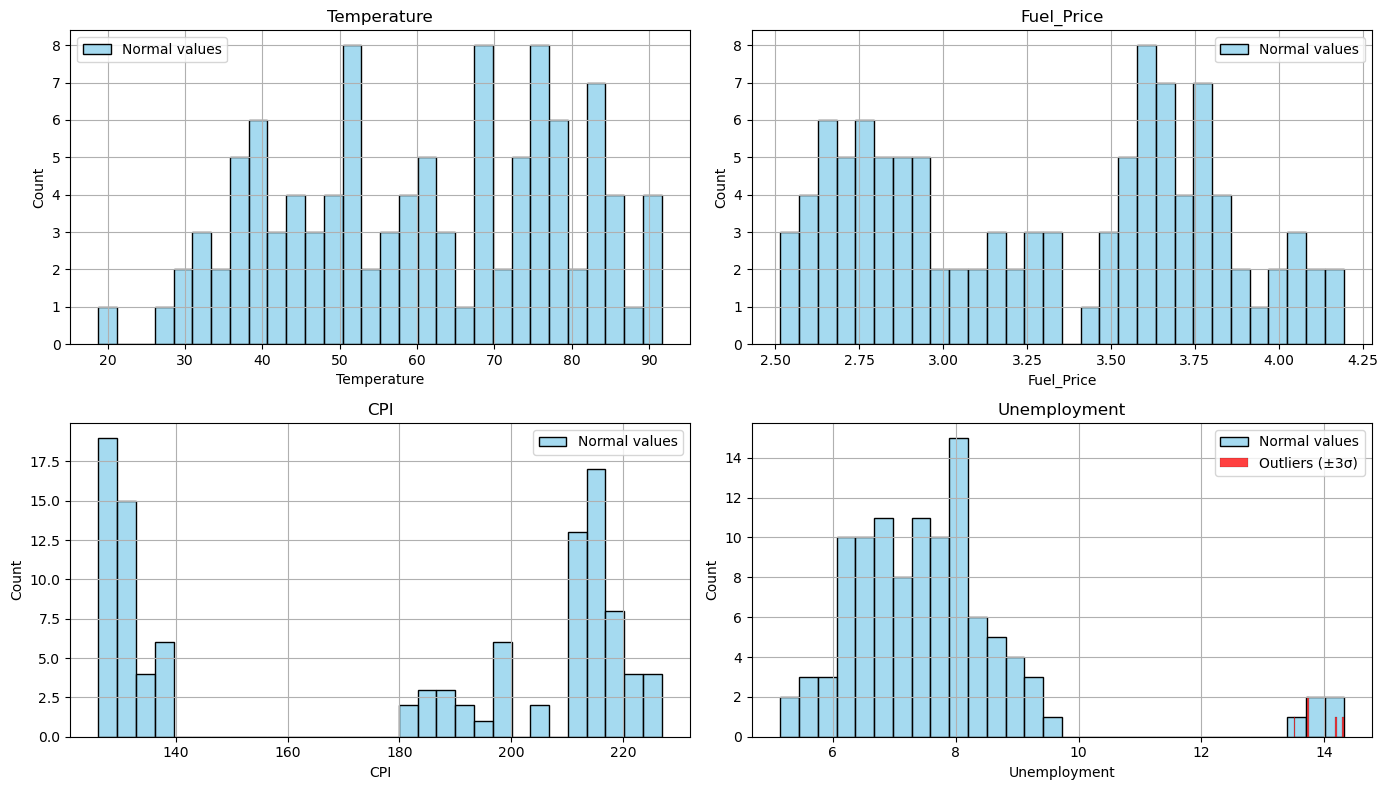

In [16]:
# Preprocessing - Look for outliers
cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

plt.figure(figsize=(14, 8))

for i, col in enumerate(cols, 1):
    mean = clear_dataset[col].mean()
    std = clear_dataset[col].std()
    
    outliers = (clear_dataset[col] < mean - 3 * std) | (clear_dataset[col] > mean + 3 * std)

    plt.subplot(2, 2, i)
    sns.histplot(clear_dataset[col], label="Normal values", color="skyblue", kde=False, bins=30)
    sns.histplot(clear_dataset[col][outliers], label="Outliers (±3σ)", color="red", kde=False, bins=30)
    plt.title(f"{col}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Remove unemployment outliers
low = clear_dataset['Unemployment'].mean() - 3 * clear_dataset['Unemployment'].std()
high = clear_dataset['Unemployment'].mean() + 3 * clear_dataset['Unemployment'].std()
clear_dataset = clear_dataset.drop(
    clear_dataset.loc[(clear_dataset['Unemployment'] <= low) | (clear_dataset['Unemployment'] >= high)].index
)

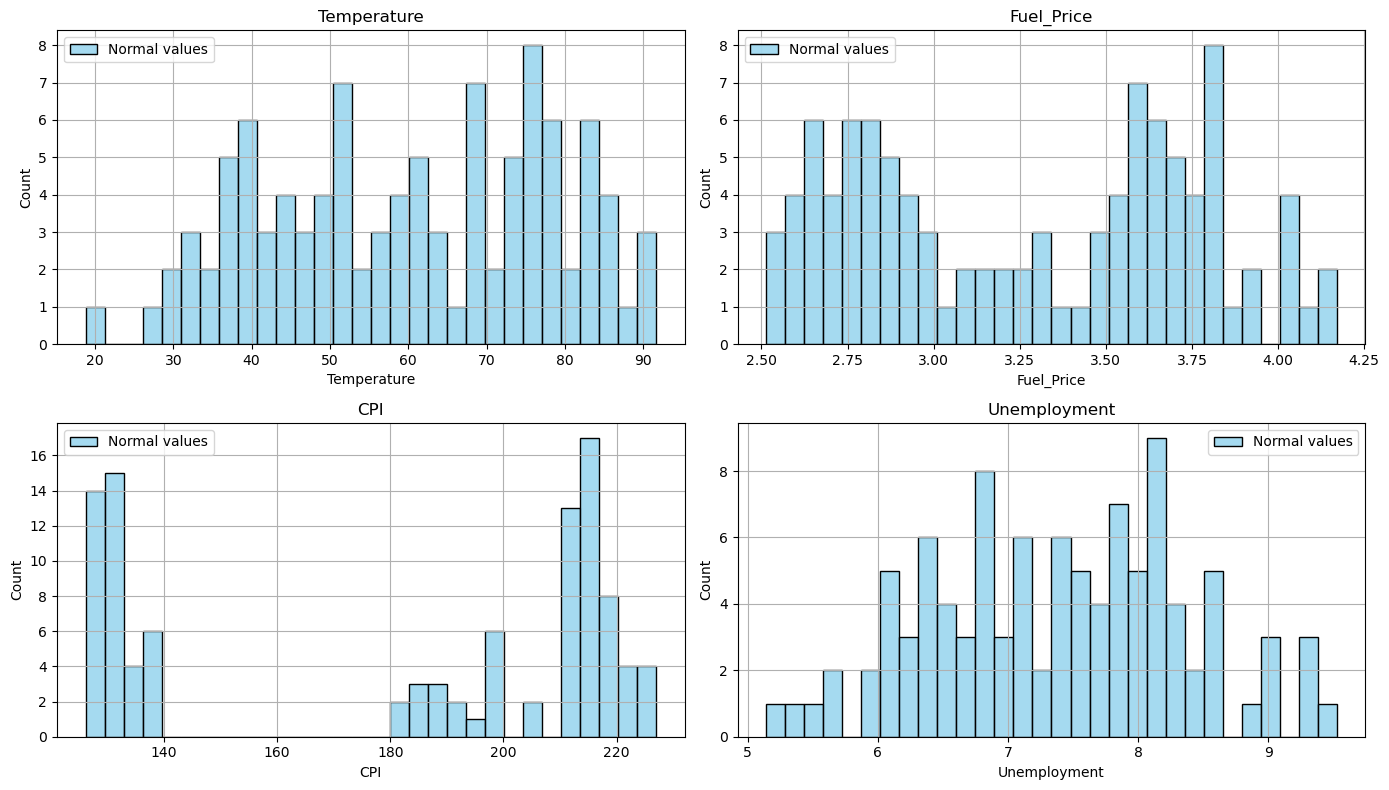

In [18]:
#Show result
cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

plt.figure(figsize=(14, 8))

for i, col in enumerate(cols, 1):
    mean = clear_dataset[col].mean()
    std = clear_dataset[col].std()
    
    outliers = (clear_dataset[col] < mean - 3 * std) | (clear_dataset[col] > mean + 3 * std)

    plt.subplot(2, 2, i)
    sns.histplot(clear_dataset[col], label="Normal values", color="skyblue", kde=False, bins=30)
    sns.histplot(clear_dataset[col][outliers], label="Outliers (±3σ)", color="red", kde=False, bins=30)
    plt.title(f"{col}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Preprocessing - Manage missing values into Holiday_Flag using Holidays 
print("Missing values before imputation:", clear_dataset["Holiday_Flag"].isna().sum())
print("Value counts before imputation:\n", clear_dataset["Holiday_Flag"].value_counts())
print()
# Get unique years from the dataset
years_in_data = clear_dataset['Date'].dt.year.unique()

# Generate US holidays only for those years
us_holidays = holidays.US(years=years_in_data)

# Impute Holiday_Flag based on real holiday dates
clear_dataset["Holiday_Flag"] = clear_dataset.apply(
    lambda row: 1 if pd.isna(row["Holiday_Flag"]) and row["Date"] in us_holidays
    else (0 if pd.isna(row["Holiday_Flag"]) else row["Holiday_Flag"]),
    axis=1
)

# Convert to integer
clear_dataset["Holiday_Flag"] = clear_dataset["Holiday_Flag"].astype(int)

print("Missing values after imputation:", clear_dataset["Holiday_Flag"].isna().sum())
print("Value counts after imputation:\n", clear_dataset["Holiday_Flag"].value_counts())


Missing values before imputation: 9
Value counts before imputation:
 Holiday_Flag
0.0    97
1.0     7
Name: count, dtype: int64

Missing values after imputation: 0
Value counts after imputation:
 Holiday_Flag
0    106
1      7
Name: count, dtype: int64


In [20]:
clear_dataset.drop(columns=["Date"], inplace=True)

In [21]:
print("Percentage of missing values: ")
display(100 * clear_dataset.isnull().sum() / clear_dataset.shape[0])

Percentage of missing values: 


Store           0.000000
Weekly_Sales    0.000000
Holiday_Flag    0.000000
Temperature     8.849558
Fuel_Price      9.734513
CPI             7.964602
Unemployment    9.734513
year            0.000000
month           0.000000
day             0.000000
day_of_week     0.000000
dtype: float64

In [22]:
# Preprocessing - Separate target variable Y from features X

print("Separating labels from features...")

features_list = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment","year","month","day","day_of_week"]
target_name = "Weekly_Sales"

Y = clear_dataset.loc[:, target_name]
X = clear_dataset.drop(target_name, axis=1) 

print("...Done.")
print()

print("Y : ")
print(Y.head())
print()
print("X :")
print(X.head())

Separating labels from features...
...Done.

Y : 
0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0             0        59.61       3.045  214.777523         6.858   
1   13.0             0        42.38       3.435  128.616064         7.470   
4    6.0             0        78.89       2.759  212.412888         7.092   
5    4.0             0          NaN       2.756  126.160226         7.896   
6   15.0             0        69.80       4.069  134.855161         7.658   

   year  month  day  day_of_week  
0  2011      2   18            4  
1  2011      3   25            4  
4  2010      5   28            4  
5  2010      5   28            4  
6  2011      6    3            4  


In [23]:
# Preprocessing - Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [24]:
numeric_features = ["Temperature","Fuel_Price","CPI","Unemployment","year","day_of_week","month","day"]
categorical_features = ["Store", "Holiday_Flag"]

In [25]:
# Preprocessing - Create pipeline for numeric features
numeric_transformer=Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="mean"),
        ),
        ("scaler", StandardScaler()),
    ]
)

In [26]:
# Preprocessing - Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="most_frequent"),
        ),  
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ), 
    ]
)

In [27]:
# Preprocessing - Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [28]:
#Preprocessing X_train
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  
print()

# Preprocessings on X_test
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
) 
print("...Done.")
print(
    X_test[0:5, :]
) 
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
52     9.0             0        85.02       2.653  214.896576           NaN   
11    18.0             0        52.02       2.878  132.763355         9.331   
105   19.0             0        72.83       2.932  132.598387         8.099   
110   20.0             1        28.85       3.179  204.643227         7.484   
75    20.0             0        75.17       2.808  204.567546         7.856   

     year  month  day  day_of_week  
52   2010      6   25            4  
11   2010     10   15            4  
105  2010      7   30            4  
110  2010     12   31            4  
75   2010      6   25            4  
...Done.
[[ 1.52824945e+00 -1.36747759e+00  9.86281451e-01 -9.67330408e-16
  -1.05558715e+00  0.00000000e+00 -2.76032796e-02  1.01737744e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.0

2. Train Reference Model - Linear Regression

In [29]:
regressor = LinearRegression()

print("Training model...")
regressor.fit(X_train, Y_train)  
print("...Done.")

Training model...
...Done.


- Performance assessment

In [30]:
# Predictions on training set 
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 355585.09124367 1159355.29938788 1403098.60982157 2066897.86334844
 1925751.39058183 1993378.09109697 2170861.80479594 1583913.14514438
  608309.47251647 2435430.82890442 1425012.44373189 2050457.39423482
 1963010.32321674 1988442.98996716 1292993.22892673 1895015.95229027
  577940.55754069 1356732.09545341 1370325.28797105  922168.7875471
 2118430.29683601  330062.81192988 1976468.41972023  363264.01495491
 1650427.27893564 1847044.77913999 2037621.67177058 2047708.28745338
 2074840.9320166   683658.94625479  606434.1042874  1151700.92166614
  370649.67457154  403311.09748353 1538480.70206245 1983747.60606973
 2427756.87804595  429794.14134814 1620329.82185334 1560398.34734786
  507856.88236816  317368.86338655  403695.24855286 1491505.6134957
  756685.67597289  411578.63715934 1994109.78023765 2162634.00847892
 1757242.51        454895.21759604  944538.20767007 1480509.80572267
 2169009.6679558   138690.0555809  1399893.28404557  951527.42848

In [31]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 378501.12025534 1439255.57249924 1610241.58807787  882223.27111356
  466933.48815387 1108363.56016822 2062248.08061379 2316549.59407455
 2054918.82705111 1557403.30045123 1029671.02504803 2045617.7019931
 1120297.6495339   607686.47558959  466043.15125443   79356.42838598
  612205.50606513  168683.03779802 1810919.52958697  487763.60993983
 1924420.17546454  472644.73646539 2069806.24173903]



In [32]:
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

print(f"R² score on training set : {train_r2:.4f}")
print(f"R² score on test set     : {test_r2:.4f}")

R² score on training set : 0.9727
R² score on test set     : 0.9396


- Interpreting the model's coefficients

In [33]:
# Model coefficients
regressor.coef_

array([-3.15136155e+04, -4.12956622e+04, -9.55204939e+04, -7.19362116e+04,
        4.28220729e+03, -2.21189111e-09,  7.46686793e+04, -3.79772866e+04,
        3.55806607e+05, -1.20622816e+06,  2.79407696e+05, -1.36574732e+06,
        3.26404416e+04, -1.00006590e+06, -7.14341479e+05, -1.17239063e+06,
        2.64167763e+05,  1.61876197e+05,  1.63524645e+05,  5.46824366e+05,
       -1.02965753e+06, -1.15468221e+06, -1.09704609e+06, -6.01983400e+05,
       -2.74981852e+05,  4.02160560e+05, -5.27381130e+04])

In [34]:
column_names = []

for name, transformer, features_list in preprocessor.transformers_:
    if name == 'num':
        # Numeric features: no renaming
        column_names.extend(features_list)
    elif name == 'cat':
        # Categorical: get names from encoder
        encoder = transformer.named_steps['encoder']
        encoded_names = encoder.get_feature_names_out(features_list)
        column_names.extend(encoded_names)

# Create DataFrame with model coefficients
coefs = pd.DataFrame({
    "feature": column_names,
    "coefficient": regressor.coef_
})

# Also include absolute value for sorting (but keep original sign for interpretation)
coefs["abs_coeff"] = coefs["coefficient"].abs()
coefs_sorted = coefs.sort_values(by="abs_coeff", ascending=True)

# Display the coefficients
print("Coefficients extracted and matched with feature names:")
display(coefs_sorted)

# Plot the coefficients
fig = px.bar(
    coefs_sorted,
    x="coefficient",
    y="feature",
    orientation='h',
    title="Linear Regression Coefficients",
    labels={"coefficient": "Coefficient Value", "feature": "Feature"}
)

fig.update_layout(
    title_x=0.5,
    showlegend=False,
    margin=dict(l=120, r=20, t=60, b=40)
)

fig.show()


Coefficients extracted and matched with feature names:


,feature,coefficient,abs_coeff
5,day_of_week,-2.211891e-09,2.211891e-09
4,year,4.282207e+03,4.282207e+03
0,Temperature,-3.151362e+04,3.151362e+04
12,Store_6.0,3.264044e+04,3.264044e+04
7,day,-3.797729e+04,3.797729e+04
1,Fuel_Price,-4.129566e+04,4.129566e+04
26,Holiday_Flag_1.0,-5.273811e+04,5.273811e+04
3,Unemployment,-7.193621e+04,7.193621e+04
6,month,7.466868e+04,7.466868e+04
2,CPI,-9.552049e+04,9.552049e+04


3. Fight overfitting

- Ridge Regularization

In [35]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = {'alpha': alphas}
ridge = Ridge()
gridsearch = GridSearchCV(ridge, param_grid=param_grid, cv=3, scoring='r2', return_train_score=True)
gridsearch.fit(X_train, Y_train)

# Best Ridge Model
best_ridge = gridsearch.best_estimator_

print("Ridge Regression Grid Search:")
print(f"Best alpha       : {gridsearch.best_params_['alpha']}")
print(f"Best CV R² score : {gridsearch.best_score_:.4f}")
print(f"Train R²         : {best_ridge.score(X_train, Y_train):.4f}")
print(f"Test R²          : {best_ridge.score(X_test, Y_test):.4f}\n")

# Plot alpha vs R² from cross-validation results
results = pd.DataFrame(gridsearch.cv_results_)
results["alpha"] = results["param_alpha"].astype(float)

fig = px.line(
    results,
    x="alpha",
    y="mean_test_score",
    title="Ridge Regression: Alpha vs Cross-Validated R²",
    markers=True,
    log_x=True,
    labels={"alpha": "Alpha (log scale)", "mean_test_score": "Mean CV R²"}
)
fig.update_layout(title_x=0.5)
fig.show()

# Compare Coefficients
coef_df = pd.DataFrame({
    "Feature": column_names,
    "Linear Coef": regressor.coef_,
    "Ridge Coef": best_ridge.coef_
})
coef_df["Difference"] = coef_df["Linear Coef"] - coef_df["Ridge Coef"]
print("Coefficient comparison:")
display(coef_df.sort_values(by="Difference", key=abs, ascending=False))

Ridge Regression Grid Search:
Best alpha       : 0.01
Best CV R² score : 0.9058
Train R²         : 0.9727
Test R²          : 0.9429



Coefficient comparison:


,Feature,Linear Coef,Ridge Coef,Difference
22,Store_17.0,-1.097046e+06,-1.044372e+06,-5.267422e+04
10,Store_4.0,2.794077e+05,3.312988e+05,-5.189110e+04
18,Store_13.0,1.635246e+05,2.132165e+05,-4.969189e+04
20,Store_15.0,-1.029658e+06,-9.809474e+05,-4.871008e+04
24,Store_19.0,-2.749819e+05,-2.308445e+05,-4.413739e+04
16,Store_10.0,2.641678e+05,3.077736e+05,-4.360583e+04
23,Store_18.0,-6.019834e+05,-5.585677e+05,-4.341567e+04
21,Store_16.0,-1.154682e+06,-1.125225e+06,-2.945762e+04
19,Store_14.0,5.468244e+05,5.684888e+05,-2.166442e+04
13,Store_7.0,-1.000066e+06,-9.817431e+05,-1.832278e+04


- Lasso Regularization

In [36]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 100, 600]
}

lasso_model = Lasso(max_iter=10000)
gridsearch_lasso = GridSearchCV(
    lasso_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    return_train_score=True
)

gridsearch_lasso.fit(X_train, Y_train)

# Results summary
print("Best alpha       :", gridsearch_lasso.best_params_['alpha'])
print(f"Best CV R² score : {gridsearch_lasso.best_score_:.4f}")

# Evaluate on train/test
best_lasso_model = gridsearch_lasso.best_estimator_

train_r2 = best_lasso_model.score(X_train, Y_train)
test_r2 = best_lasso_model.score(X_test, Y_test)

print("Lasso Model Performance:")
print(f"Train R² : {train_r2:.4f}")
print(f"Test R²  : {test_r2:.4f}")

# Plot alpha vs R²
results = pd.DataFrame(gridsearch_lasso.cv_results_)
results["alpha"] = results["param_alpha"].astype(float)

fig = px.line(
    results,
    x="alpha",
    y="mean_test_score",
    title="Lasso Regression: Alpha vs Cross-Validated R²",
    markers=True,
    log_x=True,
    labels={"alpha": "Alpha (log scale)", "mean_test_score": "Mean CV R²"}
)

fig.update_layout(title_x=0.5)
fig.show()


Best alpha       : 600
Best CV R² score : 0.9161
Lasso Model Performance:
Train R² : 0.9719
Test R²  : 0.9500
